#  Решение задачи классификации при помощи пакета `torch`.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/docs/stable/nn.html
* https://pytorch.org/docs/stable/optim.html
* https://lightning.ai/docs/torchmetrics/stable/
* https://pytorch.org/docs/stable/generated/torch.no_grad.html
* https://www.learnpytorch.io/02_pytorch_classification/
* https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler
* https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb45
* https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
* https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b7
* https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
* https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss52

## Задачи для совместного разбора

1\. Обсудите подходы к решению задачи классификации на примере синтетического датасета.

In [2]:
import torch as th

In [3]:
n_samples = 1000
n_features = 4
X = th.randn(n_samples, n_features)
y = th.randint(0, 2, size=(n_samples, ))

In [4]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
  def __init__(self, n_inputs: int, n_hidden: int, n_classes: int) -> None:
    super().__init__()
    self.fc1 = nn.Linear(n_inputs, n_hidden)
    self.fc2 = nn.Linear(n_hidden, n_classes)
    self.act = nn.ReLU()

  def forward(self, X: th.Tensor) -> th.Tensor:
    # X: batch x n_inputs
    out = self.fc1(X) # batch x n_hidden
    out = self.act(out) # batch x n_hidden
    # out = X.relu() # batch x n_hidden
    # out = F.relu(out) # batch x n_hidden
    out = self.fc2(out) # batch x n_classes
    return out

In [5]:
model = Net(n_inputs=X.shape[1], n_hidden=3, n_classes=2)
y_pred = model(X)
y_pred.shape

torch.Size([1000, 2])

In [6]:
y_pred.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [7]:
y.bincount()

tensor([498, 502])

In [8]:
criterion = nn.CrossEntropyLoss()
loss = criterion(y_pred, y)

In [9]:
model = Net(n_inputs=X.shape[1], n_hidden=3, n_classes=1)
y_pred = model(X)
criterion = nn.BCEWithLogitsLoss()
loss = criterion(y_pred.flatten(), y.float())

In [10]:
model = Net(n_inputs=X.shape[1], n_hidden=3, n_classes=2)
y_pred = model(X)
y_pred[:5]

tensor([[ 0.3318, -0.1414],
        [ 0.3138, -0.5068],
        [ 0.3314, -0.1491],
        [ 0.3287, -0.1834],
        [ 0.3318, -0.1414]], grad_fn=<SliceBackward0>)

In [11]:
y_pred.softmax(dim=1)

tensor([[0.6162, 0.3838],
        [0.6944, 0.3056],
        [0.6179, 0.3821],
        ...,
        [0.6491, 0.3509],
        [0.6162, 0.3838],
        [0.6945, 0.3055]], grad_fn=<SoftmaxBackward0>)

## Задачи для самостоятельного решения

In [48]:
from torch.utils.data import TensorDataset, DataLoader,WeightedRandomSampler
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch as th
import torch.optim as optim


from torchmetrics import (
    MeanAbsoluteError, 
    MeanAbsolutePercentageError,
    MeanSquaredError,
    MeanSquaredLogError,
    Accuracy,
    Precision,
    Recall,
    F1Score)

import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.datasets import make_regression, make_circles
from sklearn.model_selection import train_test_split

import numpy as np
import time

<p class="task" id="1"></p>

1\. Используя реализацию полносвязного слоя из `torch.nn`, решите задачу классификации. Разделите датасет на обучающую и тестовую выборку в соотношении 80% на 20%. В качестве функции потерь используйте реализацию `CrossEntropyLoss` из `torch.nn`. Для настройки весов реализуйте мини-пакетный градиентный спуск с использованием `torch.optim.SGD`.

Используйте модель, состоящую из двух слоев:
1. Полносвязный слой с 10 нейронами;
2. Полносвязный слой с 2 нейронами.

Выведите график изменения значения функции потерь в процессе обучения. Выведите на экран значения Accuracy, Precision, Recall и F1 для обучающего и тестового множества.

Выведите на экран облако точек с цветом, соответствующим предсказаниям модели на всем датасете (и обучающей, и тестовой части).

- [ ] Проверено на семинаре


In [18]:
X, y = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = th.FloatTensor(X)
y = th.LongTensor(y)

train_percentage = 0.8

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42
)

In [22]:
dset = TensorDataset(X_train,y_train)
loader = DataLoader(dset, batch_size=16, shuffle=True)
model = nn.Sequential(
    nn.Linear(X.shape[1], 10),
    nn.Linear(10,2)
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.005)

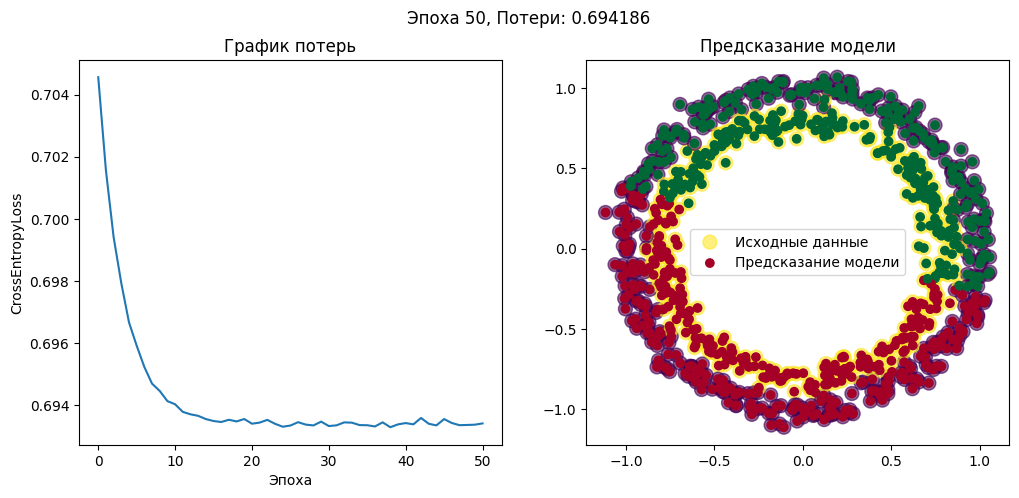

In [23]:
EPOCHS = 50
losses = []

for epoch in range(EPOCHS+1):
    e_loss = 0
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        e_loss+=loss.item()
    
    
    e_loss /= len(loader)
    losses.append(e_loss)
    if (epoch)%10==0:
    #     print(f'epoch {epoch+1}, loss {e_loss}')
        
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.plot(losses)
        ax1.set_title("График потерь")
        ax1.set_xlabel("Эпоха")
        ax1.set_ylabel("CrossEntropyLoss")
        preds = th.argmax(model(X_train).softmax(dim=1), dim=1).numpy()
        # preds_colors[preds_colors==0] = 'red'
        # preds_colors[preds_colors==1] = 'green'
        ax2.scatter(X_train.numpy()[:,0],X_train.numpy()[:,1] ,c=y_train+2, label='Исходные данные', alpha=0.6, s=100)
        ax2.scatter(X_train.numpy()[:,0],X_train.numpy()[:,1],c = preds, label='Предсказание модели', cmap='RdYlGn')
        ax2.set_title("Предсказание модели")
        ax2.legend()
        
        fig.suptitle(f"Эпоха {epoch}, Потери: {loss.item():.6f}")
        
        plt.show()
    if all([i=='0' for i in str(e_loss)[2:4]]):
        break

In [24]:
print('Train metrics')
y_final = model(X_train)
for metric in [   Accuracy,
    Precision,
    Recall,
    F1Score]:
    m = metric(task='multiclass',num_classes=2)
    print(f'{metric.__name__} = {m(y_final, y_train)}')


print('\n\nTest metrics')
y_final = model(X_test)
for metric in [   Accuracy,
    Precision,
    Recall,
    F1Score]:
    m = metric(task='multiclass',num_classes=2)
    print(f'{metric.__name__} = {m(y_final, y_test)}')

Train metrics
Accuracy = 0.5174999833106995
Precision = 0.5174999833106995
Recall = 0.5174999833106995
F1Score = 0.5174999833106995


Test metrics
Accuracy = 0.45500001311302185
Precision = 0.45500001311302185
Recall = 0.45500001311302185
F1Score = 0.45500001311302185


<p class="task" id="2"></p>

2\. Повторите задачу 1, используя другую архитектуру нейронной сети.

1. Полносвязный слой с 10 нейронами;
2. Функция активации ReLU;
3. Полносвязный слой с 2 нейронами.

- [ ] Проверено на семинаре

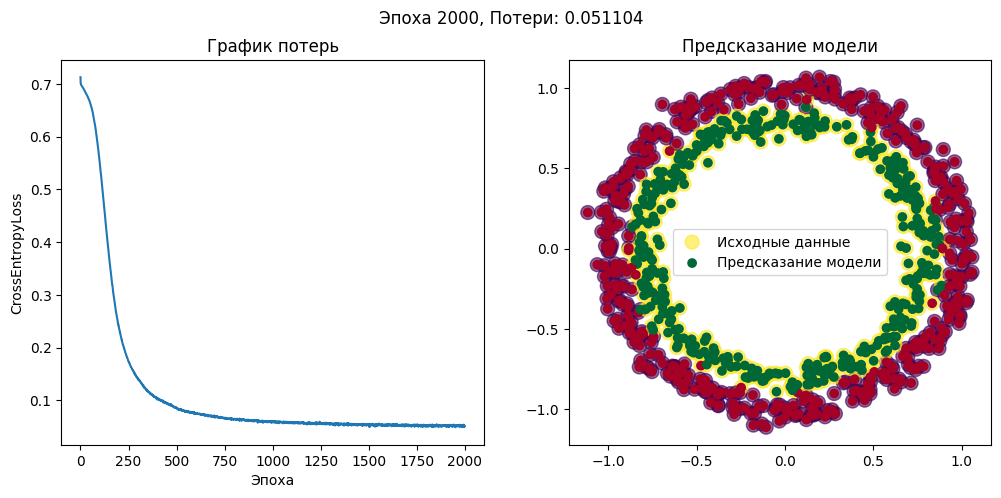

In [25]:
dset = TensorDataset(X_train,y_train)
loader = DataLoader(dset, batch_size=16, shuffle=True)
model = nn.Sequential(
    nn.Linear(X.shape[1], 10),
    nn.ReLU(),
    nn.Linear(10,2)
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.02)

EPOCHS = 2000
losses = []

for epoch in range(EPOCHS+1):
    e_loss = 0
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        # y_pred= th.argmax(model(X_batch).softmax(dim=1), dim=1)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        e_loss+=loss.item()
    
    
    e_loss /= len(loader)
    losses.append(e_loss)
    if (epoch)%10==0:
    #     print(f'epoch {epoch+1}, loss {e_loss}')
        
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.plot(losses)
        ax1.set_title("График потерь")
        ax1.set_xlabel("Эпоха")
        ax1.set_ylabel("CrossEntropyLoss")
        preds = th.argmax(model(X_train).softmax(dim=1), dim=1).numpy()
        # preds_colors[preds_colors==0] = 'red'
        # preds_colors[preds_colors==1] = 'green'
        ax2.scatter(X_train.numpy()[:,0],X_train.numpy()[:,1] ,c=y_train+2, label='Исходные данные', alpha=0.6, s=100)
        ax2.scatter(X_train.numpy()[:,0],X_train.numpy()[:,1],c = preds, label='Предсказание модели', cmap='RdYlGn')
        ax2.set_title("Предсказание модели")
        ax2.legend()
        
        fig.suptitle(f"Эпоха {epoch}, Потери: {e_loss:.6f}")
        
        plt.show()
        # break
    if all([i=='0' for i in str(e_loss)[2:4]]):
        break

In [26]:
print('Train metrics')
y_final = model(X_train)
for metric in [   Accuracy,
    Precision,
    Recall,
    F1Score]:
    m = metric(task='multiclass',num_classes=2)
    print(f'{metric.__name__} = {m(y_final, y_train)}')


print('\n\nTest metrics')
y_final = model(X_test)
for metric in [   Accuracy,
    Precision,
    Recall,
    F1Score]:
    m = metric(task='multiclass',num_classes=2)
    print(f'{metric.__name__} = {m(y_final, y_test)}')

Train metrics
Accuracy = 0.9775000214576721
Precision = 0.9775000214576721
Recall = 0.9775000214576721
F1Score = 0.9775000214576721


Test metrics
Accuracy = 0.9150000214576721
Precision = 0.9150000214576721
Recall = 0.9150000214576721
F1Score = 0.9150000214576721


<p class="task" id="3"></p>

3\. `CrossEntropyLoss` может быть использована для задачи классификации на любое количество классов. Для задачи бинарной классификации существуют специфические функции потерь. Решите задачу 2, используя `BCEWithLogitsLoss` в качестве функции потерь.

- [ ] Проверено на семинаре

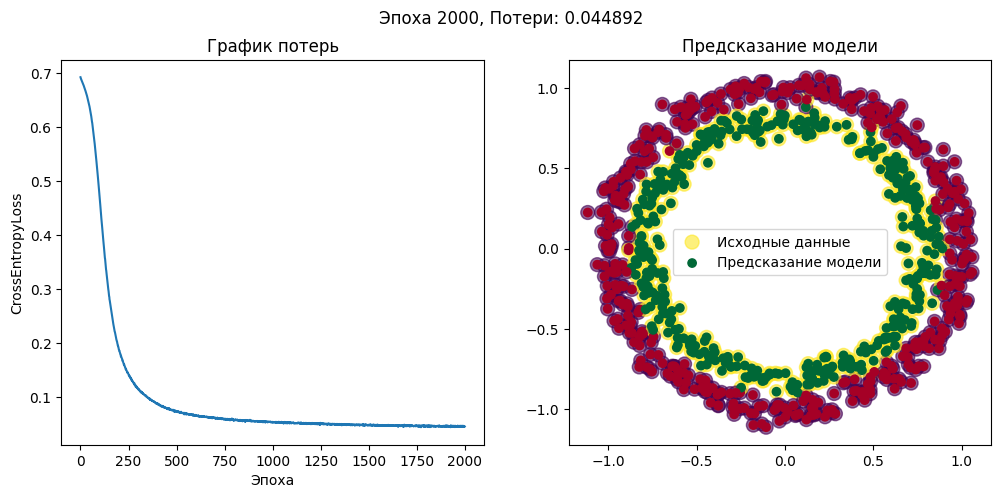

In [ ]:
dset = TensorDataset(X_train,y_train)
loader = DataLoader(dset, batch_size=16, shuffle=True)
model = nn.Sequential(
    nn.Linear(X.shape[1], 10),
    nn.ReLU(),
    nn.Linear(10,1)
)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.028)

EPOCHS = 2000
losses = []

for epoch in range(EPOCHS+1):
    e_loss = 0
    for X_batch, y_batch in loader:
        y_pred = model(X_batch).squeeze()

        loss = criterion(y_pred, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        e_loss+=loss.item()
    
    
    e_loss /= len(loader)
    losses.append(e_loss)
    if (epoch)%10==0:
        
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.plot(losses)
        ax1.set_title("График потерь")
        ax1.set_xlabel("Эпоха")
        ax1.set_ylabel("CrossEntropyLoss")
        
        with torch.no_grad():
            preds_logits = model(X_train).squeeze()
            preds = (torch.sigmoid(preds_logits) > 0.5).numpy()
            
        ax2.scatter(X_train.numpy()[:,0],X_train.numpy()[:,1] ,c=y_train+2, label='Исходные данные', alpha=0.6, s=100)
        ax2.scatter(X_train.numpy()[:,0],X_train.numpy()[:,1],c = preds, label='Предсказание модели', cmap='RdYlGn')
        ax2.set_title("Предсказание модели")
        ax2.legend()
        
        
        fig.suptitle(f"Эпоха {epoch}, Потери: {e_loss:.6f}")
        
        plt.show()
        # break
    if all([i=='0' for i in str(e_loss)[2:4]]):
        break

In [28]:
print('Train metrics')
y_final = model(X_train)
for metric in [   Accuracy,
    Precision,
    Recall,
    F1Score]:
    m = metric(task='binary')
    print(f'{metric.__name__} = {m(y_final.squeeze(1), y_train)}')


print('\n\nTest metrics')
y_final = model(X_test)
for metric in [   Accuracy,
    Precision,
    Recall,
    F1Score]:
    m = metric(task='binary')
    print(f'{metric.__name__} = {m(y_final.squeeze(1), y_test)}')

Train metrics
Accuracy = 0.9862499833106995
Precision = 0.989924430847168
Recall = 0.9825000166893005
F1Score = 0.9861982464790344


Test metrics
Accuracy = 0.925000011920929
Precision = 0.9207921028137207
Recall = 0.9300000071525574
F1Score = 0.9253731369972229


<p class="task" id="4"></p>

4\. На практике часто задача классификации является несбалансированной. В файлах каталога `imb_task` содержится несбалансированный набор данных. Обучите модель без учета несбалансированности классов (аналогично предыдущим заданиям, можно использовать любую подходящую функцию потерь). Повысьте качество модели (в смысле F1) путем модификации функции потерь (указания специального аргумента, позволяющего учесть несбалансированность классов).

- [ ] Проверено на семинаре

In [42]:
X = torch.load('imb_X.th').float()
y = torch.load('imb_y.th')

class_counts = torch.bincount(y)
print(f"Количество объектов класса 0: {class_counts[0]}")
print(f"Количество объектов класса 1: {class_counts[1]}")

Количество объектов класса 0: 1500
Количество объектов класса 1: 150


In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42, stratify=y
)

без учета дизбаланса

In [ ]:
dset = TensorDataset(X_train, y_train)
loader = DataLoader(dset, batch_size=32, shuffle=True)
model_unbalanced = nn.Sequential(
    nn.Linear(X.shape[1], 25),
    nn.ReLU(),
    nn.Linear(25, 1)
)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_unbalanced.parameters(), lr=0.01)

EPOCHS = 500
for epoch in range(EPOCHS):
    for X_batch, y_batch in loader:
        y_pred_logits = model_unbalanced(X_batch).squeeze()
        loss = criterion(y_pred_logits, y_batch.float())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def evaluate_model(model, X, y, title):
    print(title)
    model.eval()
    with torch.no_grad():
        y_final_logits = model(X).squeeze()
        
        metrics = {
            'Accuracy': Accuracy(task='binary'),
            'Precision': Precision(task='binary'),
            'Recall': Recall(task='binary'),
            'F1Score': F1Score(task='binary')
        }
        
        for name, metric in metrics.items():
            print(f'{name} = {metric(y_final_logits, y).item():.4f}')

evaluate_model(model_unbalanced, X_test, y_test, "Метрики на тестовой выборке (без учета дисбаланса):")

Метрики на тестовой выборке (без учета дисбаланса):
Accuracy = 0.9424
Precision = 1.0000
Recall = 0.3667
F1Score = 0.5366


с учетом дизбаланса

In [54]:
model_balanced = nn.Sequential(
    nn.Linear(X.shape[1], 25),
    nn.ReLU(),
    nn.Linear(25, 1)
)

class_counts = torch.bincount(y_train)
pos_weight_value = torch.sqrt(class_counts[0] / class_counts[1])
pos_weight_tensor = torch.tensor([pos_weight_value])

criterion_balanced = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer_balanced = optim.SGD(model_balanced.parameters(), lr=0.005)
EPOCHS = 2000
for epoch in range(EPOCHS):
    for X_batch, y_batch in loader:
        y_pred_logits = model_balanced(X_batch).squeeze()
        loss = criterion_balanced(y_pred_logits, y_batch.float())
        
        optimizer_balanced.zero_grad()
        loss.backward()
        optimizer_balanced.step()

evaluate_model(model_balanced, X_test, y_test, "Метрики на тестовой выборке (с учетом дисбаланса):")

Метрики на тестовой выборке (с учетом дисбаланса):
Accuracy = 0.9182
Precision = 0.5405
Recall = 0.6667
F1Score = 0.5970


F1 метрика точно стала выше(на 7% !)

<p class="task" id="5"></p>

5\. Повторите решение задачи 4, повысив качество модели за счет использования `WeightedRandomSampler` вместо модификации функции потерь.

- [ ] Проверено на семинаре

Лучший F1-score: 0.6441
Достигнут при пороге: 0.8030

Метрики на тестовой выборке:
Accuracy = 0.9364
Precision = 0.6552
Recall = 0.6333
F1Score = 0.6441


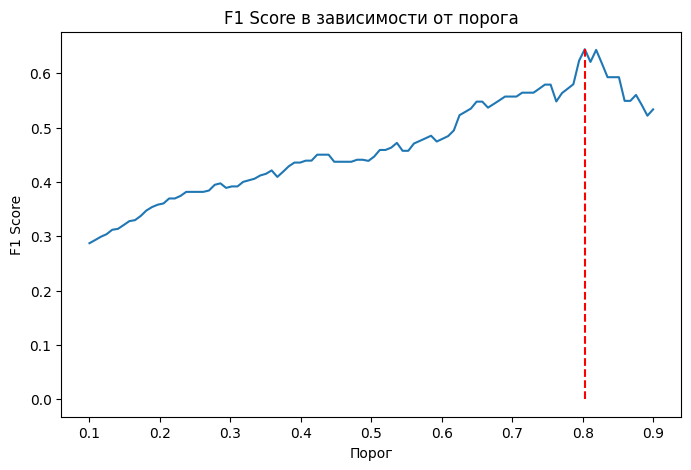

In [ ]:
class_counts_train = torch.bincount(y_train)
class_weights = 1. / class_counts_train.float()
sample_weights = torch.tensor([class_weights[label] for label in y_train])

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

dset_balanced = TensorDataset(X_train, y_train)
loader_balanced = DataLoader(dset_balanced, batch_size=32, sampler=sampler)

model_sampler = nn.Sequential(
    nn.Linear(X.shape[1], 25),
    nn.ReLU(),
    nn.Linear(25, 1)
)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_sampler.parameters(), lr=0.005)

EPOCHS = 5000
for epoch in range(EPOCHS):
    for X_batch, y_batch in loader_balanced:   
        y_pred_logits = model_sampler(X_batch).squeeze()
        loss = criterion(y_pred_logits, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


with torch.no_grad():
    y_final_logits = model_sampler(X_test).squeeze()
    y_final_probs = torch.sigmoid(y_final_logits)

thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = []
f1_metric = F1Score(task='binary')

for thresh in thresholds:
    preds = (y_final_probs > thresh).int()
    f1_scores.append(f1_metric(preds, y_test).item())

best_f1 = max(f1_scores)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Лучший F1-score: {best_f1:.4f}")
print(f"Достигнут при пороге: {best_threshold:.4f}")

print("\nМетрики на тестовой выборке:")
metrics = {
    'Accuracy': Accuracy(task='binary', threshold=best_threshold),
    'Precision': Precision(task='binary', threshold=best_threshold),
    'Recall': Recall(task='binary', threshold=best_threshold),
    'F1Score': F1Score(task='binary', threshold=best_threshold)
}
for name, metric in metrics.items():
    print(f'{name} = {metric(y_final_logits, y_test).item():.4f}')

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores)
plt.title('F1 Score в зависимости от порога')
plt.xlabel('Порог')
plt.ylabel('F1 Score')
plt.vlines(best_threshold, 0, best_f1, colors='r', linestyles='--')
plt.show()

F1 метрика точно стала еще выше(на 11% ! относительно обучения без учета дизбаланса)